# Bucket Lab: 
## A playground for understanding hydrologic process representations with Deep Learning and Information Theory

This notebook is designed to help students understand the fundamentals of simulating dynamic systems with Deep Learning. The data is completely generated synthetically in this notebook, including dynamic forcings representing precipitation and evapotranspiration, representations of the hydrological system (leaking buckets) with a variety of attributes, "ground truth" representations of water level and fluxes out of the buckets. This notebook allows the user to experiment with modifications to any aspect of the system. 

(This cell can be removed after we finish)

- Updated by Jonathan April 26, 2023
    Edited variable names to match the preprint
    Edited the evaporation equation. But it is completely artificial, may want to make it more realistic.
- Updated by Jonathan April 26, 2023
    I am modifying the section titles, and order to match the flow of the preprint
    Adding back in the infiltration loss, which I took out for some reason at some point.

- Updated by Jonathan
    Add option to run with GPU
    little tweaks

- Update by Leila Hernandez R on April 18, 2023: 
    I check and ran all cells in the code, and it's working well. 
    I added a brief explanation in some cells. I added sections 7 and 8. Section 7 increase the number of training buckets, 
    store the results, and plot loss and RMSE. Section 8 uses Entropy and MI as metrics and needs more work.

# Setup notebook

The first thing to do is setup the notebook with all the libraries, variables, constants and global parameters declared.

### 2.1.1 Notebook environment with standard libraries 
Here we import standard libraries for data management, calculations and plotting. 
Also, we import machine learning libraries for modeling architectures, training, validation and testing.

In [1]:
# Import standard python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Import machine learning python libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

### 2.1.2 Global constants, variables and model parameters 
This cell includes values to define the system we want to represent and the model hyperparameters. 
In a typical full-scale modeling framework, these would be decalared in a configuration file.

In [2]:
# global variables
g = 9.807         #[m/s^2]
time_step = 1     #[s]

# Set the splits for training, validation and testing
# Back propogation should be done on the "train" set
# Hyperparameter tuning should be done on the "val" set
# Calculating model accuracy should be done on the "test" set
n_buckets_split = {"train":35, "val":5,"test":1}
time_splits = {"train":2500, "val":1500,"test":200}

# Parameters for the forcing processes
# These data are created with a simple random process that decides if it is raining and how much, from the previous state. 
# Three possibilities of precipitation type are:   
rain_probability_range = {
    "None":[0.6, 0.7],       # 1) no precipitation, 
    "Light":[0.5, 0.8],      # 2) light precipitation, and,
    "Heavy":[0.2, 0.3]       # 3) heavy precipitation.  
}
# The total ammount of rain is determined by a random uniform distribution.
# 1) Light: between zero and P_Light.
# 2) Heavy: between P_Light and P_Heavy
rain_max = {"Light":2, "Heavy":8}

# Bucket attributes
# These set the diversity in the bucket sizes
bucket_attributes_range = {
    "A_bucket":[1.0,2.0], #[m^2]
    "A_spigot":[0.1,0.2], #[m^2]
    "H_bucket":[5.0, 6.0], #[m]
    "H_spigot":[1.0, 3.0], #[m]
    "K_infiltration": [1e-7, 1e-9],
    "ET_parameter": [7,9]
}
bucket_attributes_list = list(bucket_attributes_range.keys())

# Add noise to the data, because real world systems are noisy
is_noise=True
noise = {"pet":0.1,    # Noise added to the potential loss to evaporation from the bucket
         "et":0.1,  # Noise added to the loss to evaporation from the bucket
         "q":0.1,   # Noise added to the loss of fluxes out from the bucket
         "head":0.1    # Noise added to the state of the water head in the bucket
        }  

# LSTM hyperparameters
if torch.cuda.is_available():
    device = torch.device("cuda:0")#torch.cuda.device(0)
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device='cpu'
hidden_state_size = 16
num_layers= 8
num_epochs = 5  
batch_size = 256 
seq_length= 24
learning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)

Using CUDA device:  NVIDIA GeForce RTX 3090


### 2.1.3 Derived lists and values for setting up the splits in the data
Some simple calculations that take the split data from above and creates the values needed to modify the data below.

In [3]:
# Calculating splits from the settings above

# Bucket splits
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]
buckets_for_training = list(range(0, n_buckets_split['train']+1))
buckets_for_val = list(range(n_buckets_split['train']+1, n_buckets_split['train']+n_buckets_split['val']+1))
buckets_for_test = list(range(n_buckets - n_buckets_split['test'], n_buckets))

# Time splits
train_start = seq_length
train_end   = time_splits["train"]
val_start   = train_end + seq_length
val_end     = val_start + time_splits["val"]
test_start  = val_end + seq_length
test_end    = test_start + time_splits["test"]

# Define buckets (Boundary conditions)
buckets = {bucket_attribute:[] for bucket_attribute in bucket_attributes_list}
for i in range(n_buckets):
    for attribute in bucket_attributes_list:
        buckets[attribute].append(np.random.uniform(bucket_attributes_range[attribute][0], 
                                                    bucket_attributes_range[attribute][1]))
        
# Initial conditions
h_water_level = [np.random.random() for i in range(n_buckets)]
mass_overflow = [np.random.random() for i in range(n_buckets)]

### 2.1.4 Variations on the system inputs, creating the synthetic "precipitation"
These data are created with a simple random process that decides if it is raining, and how much, from the previous state. Three possibilities of precipitation type are  
1) no precipitation, 2) light precipitation and 3) heavy precipitation.  

The total ammount of rain is determined by a random uniform distribution between zero and P. To simulate a more "flashy" system, for instance, reduce the probability of heavy precipitation and increase the magnitude.

In [4]:
# Generate some synthetic "precipitation" as input
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length*3
in_list = {i:[0] for i in range(n_buckets)}
for bucket in range(n_buckets):
    
    no_rain_probability = np.random.uniform(rain_probability_range["None"][0],
                                            rain_probability_range["None"][1])
    heavy_rain_probability = np.random.uniform(rain_probability_range["Heavy"][0],
                                            rain_probability_range["Heavy"][1])
    light_rain_probability = np.random.uniform(rain_probability_range["Light"][0],
                                            rain_probability_range["Light"][1])
    
    for i in range(1,num_records):

        # some percent of time we have no rain at all
        if np.random.uniform(0.01,0.99) < no_rain_probability:
            in_list[bucket].append(0)

        # When we do have rain, the probability of heavy or light rain depends on the previous day's rainfall
        else:

            # If yesterday was a light rainy day, or no rain, then we are likely to have light rain today
            if in_list[bucket][i-1] < rain_max["Light"]:
                if np.random.uniform(0,1) < light_rain_probability:
                    in_list[bucket].append(np.random.uniform(0,1))
                else:
                    # But if we do have heavy rain, then it could be very heavy
                    in_list[bucket].append(np.random.uniform(rain_max["Light"],rain_max["Heavy"]))

            # If it was heavy rain yesterday, then we might have heavy rain again today
            else:
                if np.random.uniform(0,1) < heavy_rain_probability:
                    in_list[bucket].append(np.random.uniform(0,1))
                else:
                    in_list[bucket].append(np.random.uniform(0,rain_max["Light"]))

### 2.1.5 Bucket model numerical simulations as "ground truth"
These represent the data we know about the system, which is what we will try to learn with the LSTM. Even though these are synthetic data, the process representations of a leaking bucket are much simpler than, say, a watershed. So we can be a little more confident that our synthetic leaking buckets represent a real-world system.

In [5]:
bucket_dictionary = {}

for ibuc in range(n_buckets):
    
    # Memory to store model results
    columns = ['precipitaion','et', 'h_bucket', 'q_overflow', 'q_spigot']
    columns.extend(bucket_attributes_list)
    df = pd.DataFrame(index=list(range(len(in_list[ibuc]))),columns=columns)
    
    # Main loop through time
    for t, precip_in in enumerate(in_list[ibuc]):
        
        # Add the input mass to the bucket
        h_water_level[ibuc] = h_water_level[ibuc] + precip_in

        # Lose mass out of the bucket. Some periodic type loss, evaporation, and some infiltration...
        et = np.max([0, (buckets["A_bucket"][ibuc] / buckets["ET_parameter"][ibuc]) * np.sin(t) * np.random.normal(1,noise['pet'])])
        infiltration = h_water_level[ibuc] * buckets["K_infiltration"][ibuc]
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - et)])
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - infiltration)])
        if is_noise:
            h_water_level[ibuc] = h_water_level[ibuc] * np.random.normal(1, noise['et'])

        # Overflow if the bucket is too full
        if h_water_level[ibuc] > buckets["H_bucket"][ibuc]:
            mass_overflow[ibuc] = h_water_level[ibuc] - buckets["H_bucket"][ibuc]
            h_water_level[ibuc] = buckets["H_bucket"][ibuc] 
            if is_noise:
                h_water_level[ibuc] = h_water_level[ibuc] - np.random.uniform(0, noise['q'])

        # Calculate head on the spigot
        h_head_over_spigot = (h_water_level[ibuc] - buckets["H_spigot"][ibuc] ) 
        if is_noise:
            h_head_over_spigot = h_head_over_spigot * np.random.normal(1, noise['head'])

        # Calculate water leaving bucket through spigot
        if h_head_over_spigot > 0:
            velocity_out = np.sqrt(2 * g * h_head_over_spigot)
            spigot_out = velocity_out *  buckets["A_spigot"][ibuc] * time_step
            h_water_level[ibuc] = h_water_level[ibuc] - spigot_out
        else:
            spigot_out = 0

        # Save the data in time series
        df.loc[t,'precipitation'] = precip_in
        df.loc[t,'et'] = et
        df.loc[t,'h_bucket'] = h_water_level[ibuc]
        df.loc[t,'q_overflow'] = mass_overflow[ibuc]
        df.loc[t,'q_spigot'] = spigot_out
        for attribute in bucket_attributes_list:
            df.loc[t,attribute] = buckets[attribute][ibuc]

        mass_overflow[ibuc] = 0
        
    #Now stick that bucket specific data into the general dictionary
    bucket_dictionary[ibuc] = df

# Set some lists and values based on the input and output variables
input_vars = ['precipitation','et']
input_vars.extend(bucket_attributes_list)
output_vars = ['q_overflow', 'q_spigot']
n_input=len(input_vars)
n_output=len(output_vars)

### 2.1.6 Visualize a sample of the bucket fluxes
As means to make sure the values are realistic, and that they have both fluxes from the spigot (channel flow) and over the top (flooding)

Bucket: 36
Overflow mean: 0.35
Overflow max: 7.86


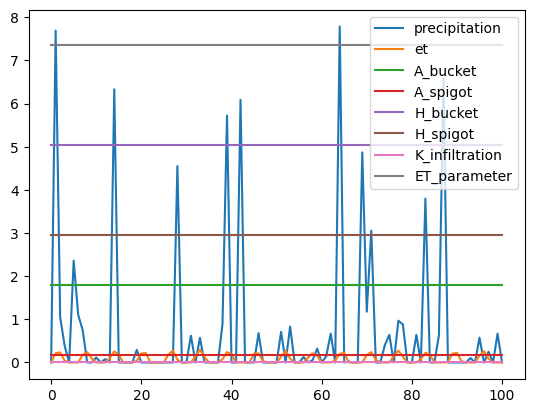

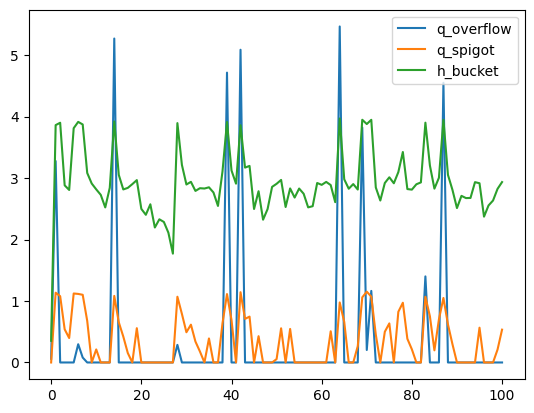

Bucket: 37
Overflow mean: 0.22
Overflow max: 6.71


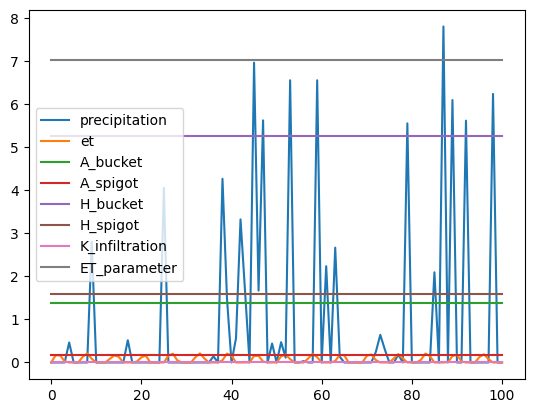

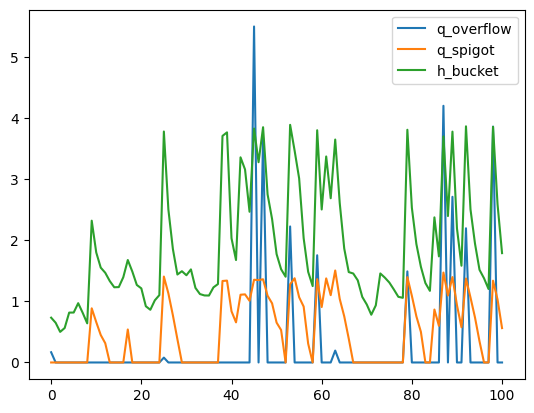

Bucket: 38
Overflow mean: 0.26
Overflow max: 7.75


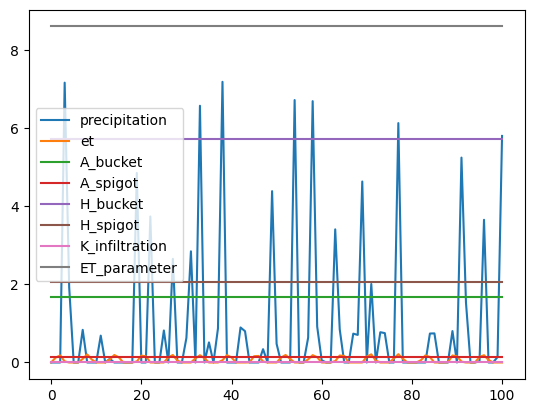

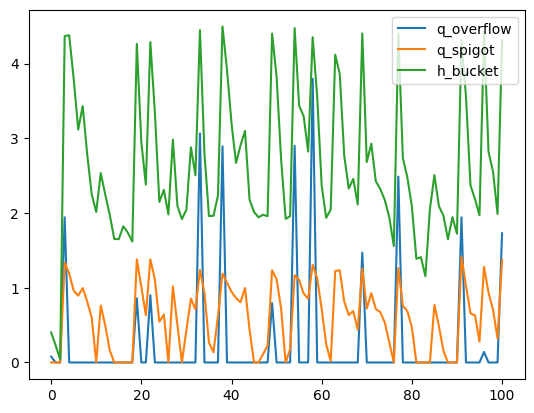

Bucket: 39
Overflow mean: 0.22
Overflow max: 7.61


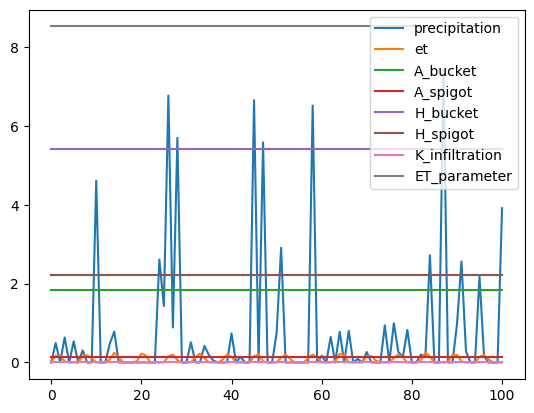

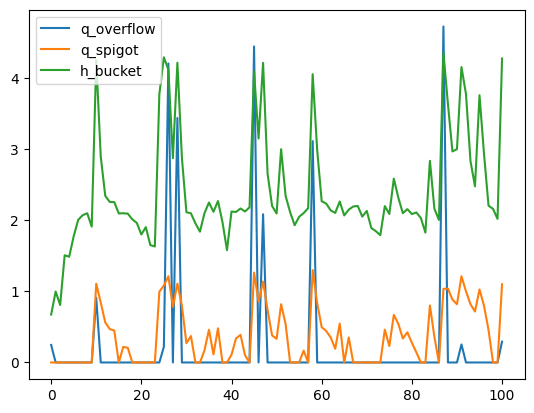

Bucket: 40
Overflow mean: 0.24
Overflow max: 7.74


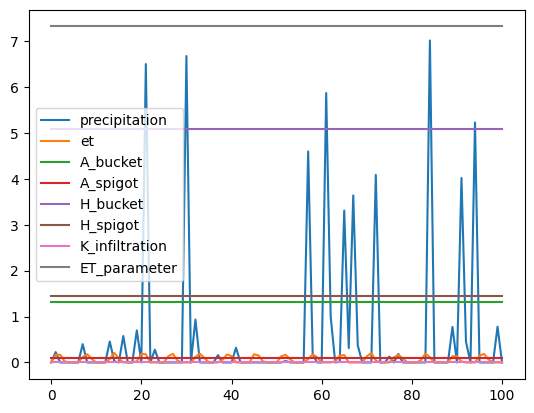

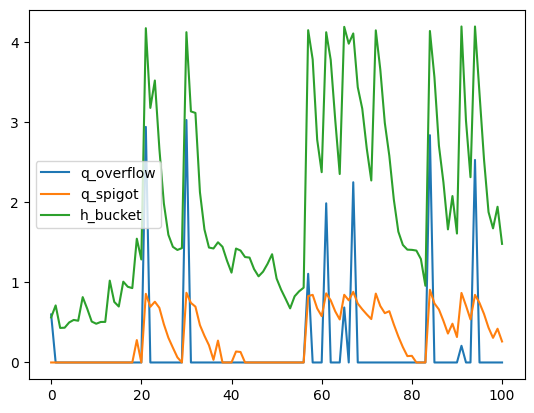

In [6]:
# Check to make sure that the is mass going over the top of the bucket
for ibuc in buckets_for_val:
    print('Bucket:', ibuc)
    print("Overflow mean:", np.round(bucket_dictionary[ibuc].q_overflow.mean(),2))
    print("Overflow max:", np.round(bucket_dictionary[ibuc].q_overflow.max(),2))
    bucket_dictionary[ibuc].loc[:100,input_vars].plot()
    bucket_dictionary[ibuc].loc[:100,output_vars].plot()
    bucket_dictionary[ibuc].loc[:100,"h_bucket"].plot()
    plt.legend()
    plt.show()
    plt.close()

# Deep learning model
This section sets up our deep learning model and training procedure.

### 2.1.7 Define the neural network model
This is the part of the notebook that will actually be learning and making the predictions.

Brief explanation:
The next cell defines a class called LSTM1, which is a PyTorch module for a single-layer Long Short-Term Memory (LSTM) network. 
The input to the module is a tensor x of shape (batch_size, seq_length, input_size), which represents a sequence of batch_size samples, each of length seq_length, with input_size features at each time step. 
The LSTM layer is defined using the nn.LSTM class, with input_size as the size of the input layer, hidden_size as the size of the hidden state, and batch_first=True indicating that the first dimension of the input tensor is the batch size. 
The output of the LSTM layer is passed through a ReLU activation function, and then to a fully connected layer (nn.Linear) with num_classes output units. 
The forward method takes the input tensor x as an argument, along with an optional tuple init_states representing the initial hidden and internal states of the LSTM layer, and returns the output tensor prediction. 
If init_states is not provided, it is initialized as a tensor of zeros with shape (batch_size, hidden_size).

In [7]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True) #lstm
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(batch_size, self.hidden_size)) #hidden state
            c_t = Variable(torch.zeros(batch_size, self.hidden_size)) #internal state
        else:
            h_t, c_t = init_states
           
        out, _ = self.lstm(x)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction

### 2.1.8 Define a procedure for validation
This is to make sure that our model is working the way we want it to.  
This would be the thing to check when changing hyperparameters.

Brief explanation:
In this cell we define how to validate and test the LSTM model, as well as check the water balance of the system.
We use a pre-defined the LSTM model to make predictions on the validation data. 
The output of this model is then used to compute two different metrics, the Nash-Sutcliffe Efficiency (NSE) for the spigot_out and mass_overflow columns of the dataframe.
Next, the function plots the actual spigot_out and mass_overflow values against their corresponding LSTM predictions. Finally, it checks the water balance of the system by summing up the input, evapotranspiration, mass_overflow, spigot_out, and the last recorded water level in the dataframe, and compares this to the total mass out of or left in the system. It then prints out the percent mass residual as a measure of how well the system is balanced.

In [8]:
def check_validation_period(lstm, np_val_seq_X, ibuc, n_plot=100):

    """ Validation procedure
    """
    
    df = bucket_dictionary[ibuc]
    
    lstm_output_val = lstm(torch.Tensor(np_val_seq_X[ibuc]).to(device=device))
    
    val_spigot_prediction = []
    val_overflow_prediction = []
    for i in range(lstm_output_val.shape[0]):
        val_spigot_prediction.append((lstm_output_val[i,-1,1].cpu().detach().numpy() * \
                                np.std(df.loc[train_start:train_end,'q_spigot'])) + \
                               np.mean(df.loc[train_start:train_end,'q_spigot']))
        
        val_overflow_prediction.append((lstm_output_val[i,-1,0].cpu().detach().numpy() * \
                                np.std(df.loc[train_start:train_end,'q_overflow'])) + \
                               np.mean(df.loc[train_start:train_end,'q_overflow']))
        
    spigot_out = df.loc[val_start:val_end, 'q_spigot']
    spigot_mean = np.mean(spigot_out)
    spigot_pred_variance = 0
    spigot_obs_variance = 0

    overflow_out = df.loc[val_start:val_end, 'q_overflow']
    overflow_mean = np.mean(overflow_out)
    overflow_pred_variance = 0
    overflow_obs_variance = 0

    for i, pred_spigot in enumerate(val_spigot_prediction):
        t = i + seq_length - 1
        spigot_pred_variance += np.power(( pred_spigot          - spigot_out.values[t]), 2)
        spigot_obs_variance  += np.power(( spigot_mean          - spigot_out.values[t]), 2)

    for i, pred_overflow in enumerate(val_overflow_prediction):
        t = i + seq_length - 1
        overflow_pred_variance += np.power((pred_overflow          - overflow_out.values[t]), 2)
        overflow_obs_variance  += np.power((overflow_mean          - overflow_out.values[t]), 2)
        
    print("Spigot NSE",   np.round( 1 - ( spigot_pred_variance   / spigot_obs_variance   ), 4))
    print("Overflow NSE", np.round( 1 - ( overflow_pred_variance / overflow_obs_variance ), 4))
        
    plt.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'q_spigot'].values, label="Spigot out")
    plt.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'q_overflow'].values, label="Overflow")
    plt.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
    plt.legend()
    plt.show()
    plt.close()

    # ------------------------------------------------------------------------------------------------- #
    # Check the water balance of the system
    df = bucket_dictionary[ibuc]
    
    print("Mass into the system: ", df.sum()['precipitation'])
    mass_out_of_or_left_in_the_bucket = df.sum()['et'] + \
                                        df.sum()['q_overflow']        + \
                                        df.sum()['q_spigot']           + \
                                        df.loc[num_records-1,'h_bucket']
    
    print("Mass out or left over:", mass_out_of_or_left_in_the_bucket)
    print("percent mass resudual: {:.0%}".format((df.sum()['precipitation']-mass_out_of_or_left_in_the_bucket) / \
                                             df.sum()['precipitation']))

### 2.1.9 Instantiate the neural network model

Using the hyperparameters from Section 1.2, we define a specific instance of the LSTM model.

In [9]:
# Set up the LSTM
torch.manual_seed(1)
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)


### 2.1.10 Setup the data, including splits, for training, validation and testing
This is what will actually be fed into the model for:
1. training, to calculate the loss which is backpropogated through the model
2. validationa, where we get predictions from the trained model and see if the performance is up to our standards
3. testing, the last thing we would do, and the data we will report. Once the training performance is calculated, cannot go back to validation, otherwise that would be P-hacking.

In [10]:
# Make all the splits for the model

train_loader={}
test_loader={} 
val_loader={}
np_train_seq_X={}
np_train_seq_y={}
np_val_seq_X={}
np_val_seq_y={}
np_test_seq_X={}
np_test_seq_y={}
        
# Fit all data to the training set
frames = [bucket_dictionary[ibuc].loc[train_start:train_end,input_vars] for ibuc in buckets_for_training]
df_in = pd.concat(frames)    
scaler_in = StandardScaler()
scaler_train_in = scaler_in.fit_transform(df_in)

frames = [bucket_dictionary[ibuc].loc[train_start:train_end,output_vars] for ibuc in buckets_for_training]
df_out = pd.concat(frames)    
scaler_out = StandardScaler()
scaler_train_out = scaler_out.fit_transform(df_out)

# ------------------------------------------------------------------------------------------------- #
# Training data splits
for ibuc in buckets_for_training:

    df = bucket_dictionary[ibuc]
    
    scaler_test_in = scaler_in.transform(df.loc[test_start:test_end,input_vars])
    scaler_test_out = scaler_out.transform(df.loc[test_start:test_end,output_vars])

    np_train_seq_X[ibuc] = np.zeros((scaler_train_in.shape[0] - seq_length, seq_length, n_input))
    np_train_seq_y[ibuc] = np.zeros((scaler_train_out.shape[0] - seq_length, seq_length, n_output))
    for i in range(0, scaler_train_in.shape[0] - seq_length):
        t = i+seq_length
        np_train_seq_X[ibuc][i, :, :] = scaler_train_in[i:t,:]
        np_train_seq_y[ibuc][i, :, :] = scaler_train_out[i:t,:]
        
    ds_train = torch.utils.data.TensorDataset(torch.Tensor(np_train_seq_X[ibuc]), 
                                              torch.Tensor(np_train_seq_y[ibuc]))
    train_loader[ibuc] = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)

# ------------------------------------------------------------------------------------------------- #
# Validation data splits
for ibuc in buckets_for_val:

    df = bucket_dictionary[ibuc]
       
    scaler_val_in = scaler_in.transform(df.loc[val_start:val_end,input_vars])
    scaler_val_out = scaler_out.transform(df.loc[val_start:val_end,output_vars])
                                                                                           
    np_val_seq_X[ibuc] = np.zeros((scaler_val_in.shape[0] - seq_length, seq_length, n_input))
    np_val_seq_y[ibuc] = np.zeros((scaler_val_out.shape[0] - seq_length, seq_length, n_output))
    for i in range(0, scaler_val_in.shape[0] - seq_length):
        t = i+seq_length
        np_val_seq_X[ibuc][i, :, :] = scaler_val_in[i:t,:]
        np_val_seq_y[ibuc][i, :, :] = scaler_val_out[t,:]

        
    ds_val = torch.utils.data.TensorDataset(torch.Tensor(np_val_seq_X[ibuc]), 
                                            torch.Tensor(np_val_seq_y[ibuc]))
    val_loader[ibuc] = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=True)

# ------------------------------------------------------------------------------------------------- #
# Test data splits
for ibuc in buckets_for_test:
    
    df = bucket_dictionary[ibuc]
    
    scaler_test_in = scaler_in.transform(df.loc[test_start:test_end,input_vars])
    scaler_test_out = scaler_out.transform(df.loc[test_start:test_end,output_vars])
    
    np_test_seq_X[ibuc] = np.zeros((scaler_test_in.shape[0] - seq_length, seq_length, n_input))
    np_test_seq_y[ibuc] = np.zeros((scaler_test_out.shape[0] - seq_length, seq_length, n_output))
    for i in range(0, scaler_test_in.shape[0] - seq_length):
        t = i+seq_length
        np_test_seq_X[ibuc][i, :, :] = scaler_test_in[i:t,:]
        np_test_seq_y[ibuc][i, :, :] = scaler_test_out[i:t,:]


    ds_test = torch.utils.data.TensorDataset(torch.Tensor(np_test_seq_X[ibuc]), 
                                             torch.Tensor(np_test_seq_y[ibuc]))
    test_loader[ibuc] = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True)
    

### 2.1.11 Training the model: Learning the general response of the example dynamic ''hydrologic" system
Now is the time to train the model. Everything above was done in preparation for this step.

Here we train the LSTM neural network model with a custom loss function using the Adam optimizer. The training is done for a specified number of epochs and for each epoch, the training data is divided into buckets. For each bucket, the data is loaded using a PyTorch DataLoader and passed through the LSTM model. The output is then compared with the target values using the custom loss function. The gradients are calculated and the optimizer is used to update the weights of the model. We use the tqdm library to show the progress of the training. Finally, we estimate the average RMSE for each epoch. 

In [11]:
criterion = nn.MSELoss()  # Use costome loss function. 
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])
epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]), leave=False, disable=True)

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            batch_bar.set_postfix(loss=loss.to(device).item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))

        meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(meanrmse),
                              epoch=epoch)
        batch_bar.update()
    
    𝗰𝗹𝗲𝗮𝗿_𝗼𝘂𝘁𝗽𝘂𝘁 

Training:   0%|          | 0/5 [00:00<?, ?it/s]

### 2.1.12 Check that the model works on the validation data
Now that we have a trained model, we can see how it works on or validation split.

Spigot NSE 0.7561
Overflow NSE 0.6478


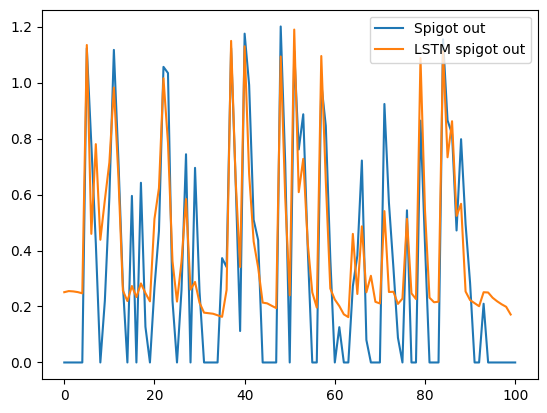

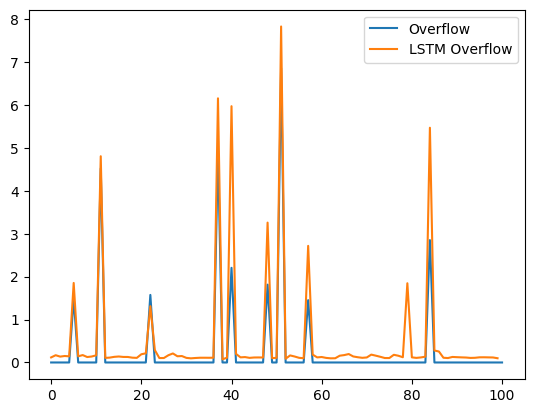

Mass into the system:  3409.5485483264515
Mass out or left over: 3372.3732610236475
percent mass resudual: 1%
Spigot NSE 0.5978
Overflow NSE 0.8666


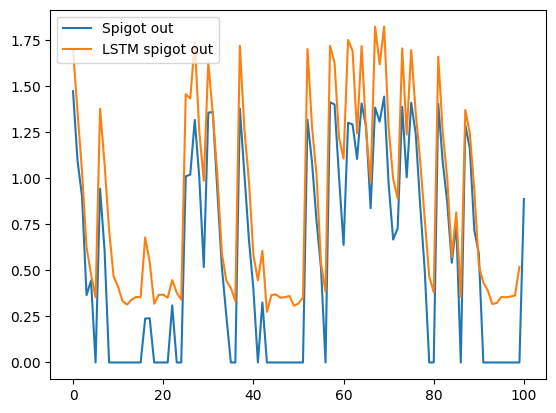

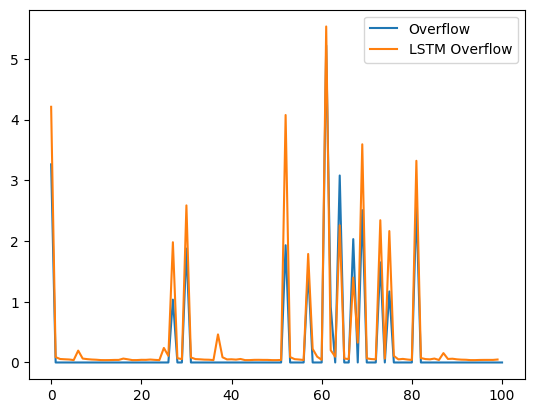

Mass into the system:  3344.6625938785287
Mass out or left over: 3341.9527328507193
percent mass resudual: 0%
Spigot NSE 0.7454
Overflow NSE 0.8924


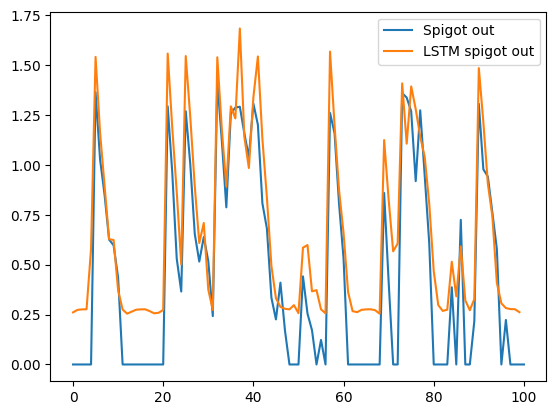

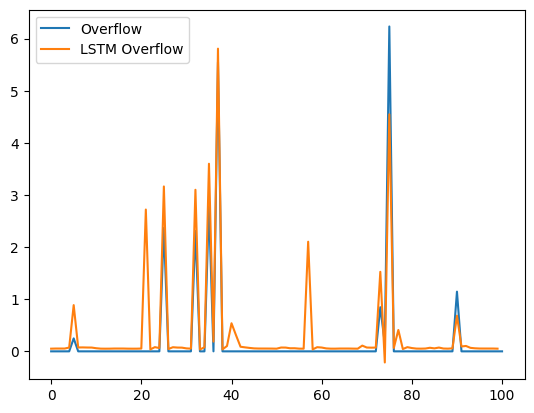

Mass into the system:  3716.8957685587084
Mass out or left over: 3706.4937233522396
percent mass resudual: 0%
Spigot NSE 0.8619
Overflow NSE 0.8892


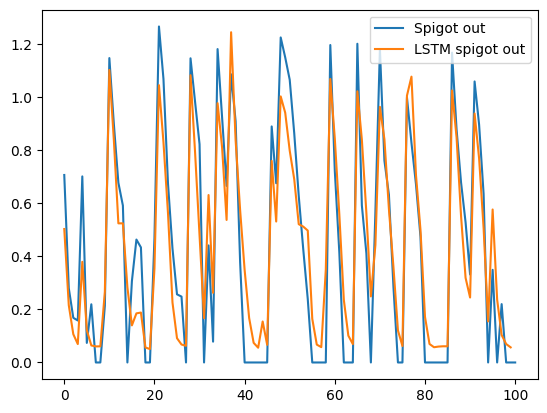

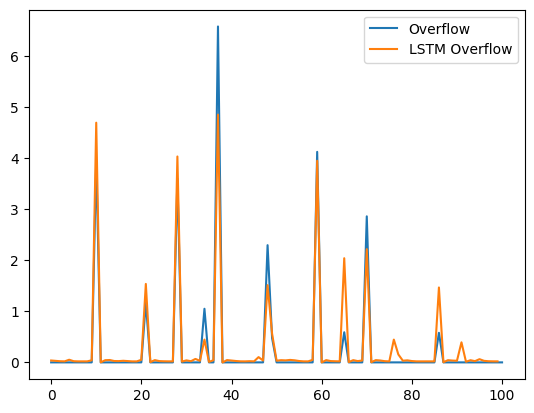

Mass into the system:  2951.6949831108896
Mass out or left over: 2955.28996635851
percent mass resudual: -0%
Spigot NSE 0.7235
Overflow NSE 0.8684


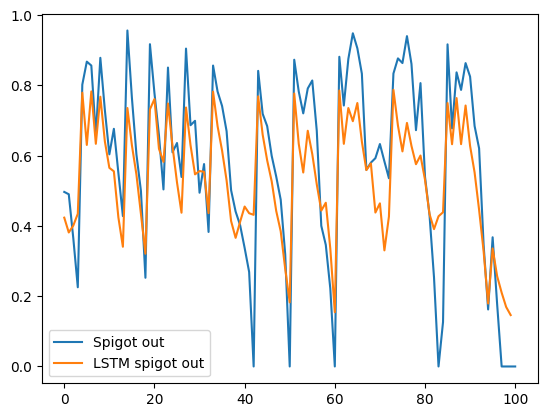

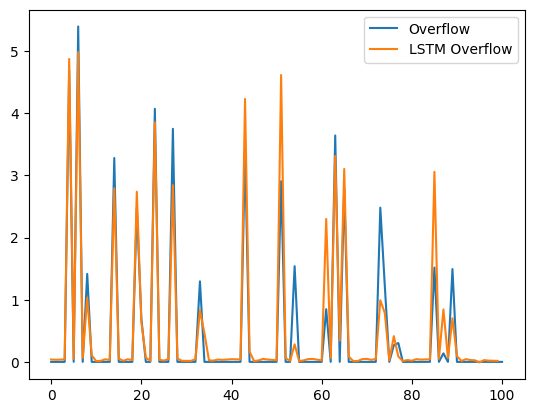

Mass into the system:  2878.4267977764894
Mass out or left over: 2860.435316295868
percent mass resudual: 1%


In [12]:
for ibuc in buckets_for_val:
    
    check_validation_period(lstm, np_val_seq_X, ibuc)

### 2.2.1 Experimentation: training with increasing the number of training buckets 
Now we will increase the number of training buckets, store the results for each bucket, and plot the comparative results for the loss and RMSE metrics.

In [13]:
#import matplotlib.pyplot as plt

criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = list(range(1, n_buckets_split["train"]-1))

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]), leave=False, disable=True)

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))

        meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(meanrmse),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(meanrmse)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
#import matplotlib.pyplot as plt

criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = list(range(1, 5))

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]), leave=False, disable=True)

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))

        meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(meanrmse),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(meanrmse)


Training:   0%|          | 0/5 [00:00<?, ?it/s]

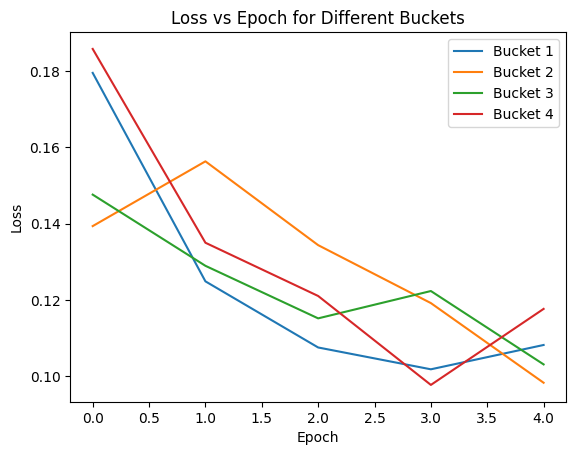

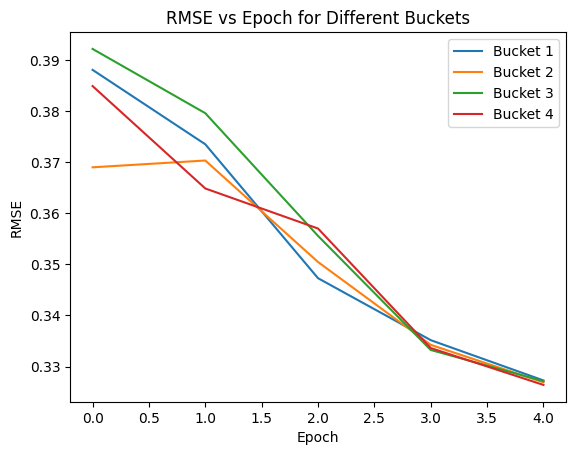

In [15]:
# Plot the comparative results
for ibuc in results:
    plt.plot(results[ibuc]["loss"], label="Bucket {}".format(ibuc))
plt.title("Loss vs Epoch for Different Buckets")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

for ibuc in results:
    plt.plot(results[ibuc]["RMSE"], label="Bucket {}".format(ibuc))
plt.title("RMSE vs Epoch for Different Buckets")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### 2.2.2 Experimentation: Evaluating the number of training buckets using Information Theory metrics
Now we use Entropy and Mutual Information as metrics of evaluation.

In [16]:
import matplotlib.pyplot as plt
#from scipy.stats import entropy, mutual_info_score
from sklearn.metrics import mutual_info_score

criterion = nn.MSELoss()  # Use costome loss function.
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])

# Increase the number of training buckets
buckets_for_training = [1, 2, 3, 4, 5]

# Create a dictionary to store the results
results = {}

epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    
    for ibuc in buckets_for_training:
        
        batch_bar = tqdm(enumerate(train_loader[ibuc]),
                         desc="Bucket: {}, Epoch: {}".format(str(ibuc),str(epoch)),
                         position=1,
                         total=len(train_loader[ibuc]))

        for i, (data, targets) in batch_bar:

            optimizer.zero_grad()

            optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            lstm_output = lstm(data) 
            loss = criterion(lstm_output,targets)

            #backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            # Compute entropy and mutual information
            entropy_val = entropy(lstm_output.cpu().detach().numpy().flatten())
            mi_val = mutual_info_score(targets.cpu().detach().numpy().flatten(), lstm_output.cpu().detach().numpy().flatten())

            batch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(loss**(1/2)),
                                  entropy="{:.2f}".format(entropy_val),
                                  MI="{:.2f}".format(mi_val),
                                  epoch=epoch)
            batch_bar.update()

        with torch.no_grad():
            rmse_list = []
            entropy_list = []
            mi_list = []
            for i, (data_, targets_) in enumerate(train_loader[ibuc]):
                data_ = data_.to(device=device)
                targets_ = targets_.to(device=device)
                lstm_output_ = lstm(data_)
                MSE_ = criterion(lstm_output_, targets_)
                rmse_list.append(MSE_**(1/2))
                entropy_val_ = entropy(lstm_output_.cpu().detach().numpy().flatten())
                mi_val_ = mutual_info_score(targets_.cpu().detach().numpy().flatten(), lstm_output_.cpu().detach().numpy().flatten())
                entropy_list.append(entropy_val_)
                mi_list.append(mi_val_)

        epoch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(np.mean(np.array(rmse_list))),
                              entropy="{:.2f}".format(np.mean(np.array(entropy_list))),
                              MI="{:.2f}".format(np.mean(np.array(mi_list))),
                              epoch=epoch)
        batch_bar.update()

        # Store the results for each bucket
        if ibuc not in results:
            results[ibuc] = {"loss": [], "RMSE": [], "entropy": [], "MI": []}
        results[ibuc]["loss"].append(loss.cpu().item())
        results[ibuc]["RMSE"].append(np.mean(np.array(rmse_list)))
        results[ibuc]["entropy"].append(np.mean(np.array(entropy_list)))
        results[ibuc]["MI"].append(np.mean(np.array(mi_list)))

# Plot the comparative results, first plot entropy 
for ibuc in results:
    plt.plot(results[ibuc]["entropy"], label="Bucket {}".format(ibuc))
plt.title("Entropy vs Epoch for Different Buckets")


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Bucket: 1, Epoch: 0:   0%|          | 0/349 [00:00<?, ?it/s]

NameError: name 'entropy' is not defined